<img style="float: right;" src="https://github.com/roldanx/oskar/blob/develop/oskar-spark/src/main/resources/OpenCB.png?raw=True">
<br>

# __Analysis tutorial__

In this tutorial you can learn how to perform some well known statistical tests to your set of data. This tests are implemented as part of the functionality of PyOskar API using the _transformers_ Spark model. These kind of functions depend directly from an _Oskar()_ object, and they will return a whole dataframe with the due transformation applied.
> <span style="color:#ff6600">__In order to optimise the performance we decided to integrate PyOskar in PySpark default API. This means that it is possible to manage data simultaneously with functions from both libraries in case we want to select specific fields, visualize the dataframe, filter the output or performing other operations besides PyOskar API.__</span>

This tutorial will show the next analysis:
 
 - ### Poblational analysis
- Hardy-Weinberg
- Inbereding Coefficient
<br>
<br>
 - ### Dataframe analysis
- Mendelian Error
- Compound Heterozygote
- Mode Of Inheritance
- Principal Component Analysis
<br>
<br>
 - ### Analysis by pairs
- Identity By State
- Identity By Descent
<br>
<br>
 - ### GWAS
- Chi-squared test
- Fisher test
- Transmission Disequilibrium Test

Let's see how it works:

First, we need to import the PyOskar and PySpark modules. Second, we need to create an instance of the _Oskar()_ object, from which depends a big part of the functionality. Finally, we must use the _load()_ transformer pointing to where the parquet file is stored to convert our data into a DataFrame _df_, and we are ready to start playing.

In [2]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("./data/platinum_chr22.small.parquet")

You can use PySpark _show()_ method to print the data from _df_. This is how our testing dataframe looks like. As you can see for this tutorial we have selected a small dataset from Illumina Platinum Genomes with 1,000 random variants from chromosome 22, which pertain to a set of 17 samples.

In [3]:
print("Print first 20 variants:")
df.show()

Print first 20 variants:
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length| type|hgvs|             studies|          annotation|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+-----+----+--------------------+--------------------+
|22:16054454:C:T|   []|        22|16054454|16054454|        C|        T|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16054454, 16...|
|22:16065809:T:C|   []|        22|16065809|16065809|        T|        C|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16065809, 16...|
|22:16077310:T:A|   []|        22|16077310|16077310|        T|        A|     +|null|     1|  SNV|  []|[[hgvauser@platin...|[22, 16077310, 16...|
|22:16080499:A:G|   []|        22|16080499|16080499|        A|        G|     +|null|     1|  SNV|  []|[[h

NOTE: With _df.printSchema()_ command you can check the dataset hierarchy and all its fields.

In [5]:
print("Samples:")
print(oskar.metadata.samples(df))

Samples:
{'hgvauser@platinum:illumina_platinum': ['NA12877', 'NA12878', 'NA12879', 'NA12880', 'NA12881', 'NA12882', 'NA12883', 'NA12884', 'NA12885', 'NA12886', 'NA12887', 'NA12888', 'NA12889', 'NA12890', 'NA12891', 'NA12892', 'NA12893']}


In [5]:
print("Total number of variants:")
df.count()

Total number of variants:


1000

 We will give a few examples of simple queries that could be of interest for the user:

# Poblational analysis

## Hardy Weinberg
This transformer calculates the Exact Test  p-value of Hardy Weinberg proportion for multiple alleles.
<br>
<br>
Usage:
```python
hardyWeinberg(df[DataFrame], studyId[str]=None)
```

In [2]:
oskar.hardyWeinberg(df, "hgvauser@platinum:illumina_platinum").select("id", "HWE").show(10)

+---------------+--------------------+
|             id|                 HWE|
+---------------+--------------------+
|22:16054454:C:T|                 1.0|
|22:16065809:T:C|                 1.0|
|22:16077310:T:A|  0.9254727474972191|
|22:16080499:A:G|                 1.0|
|22:16084621:T:C|                 1.0|
|22:16091610:G:T|                 1.0|
|22:16096040:G:A|  0.4746014089729329|
|22:16099957:C:T|0.016007636455477054|
|22:16100462:A:G|0.001011008618240...|
|22:16105660:G:A|  0.3037449017426771|
+---------------+--------------------+
only showing top 10 rows



In [8]:
oskar.hardyWeinberg(df, "hgvauser@platinum:illumina_platinum").select("id", "HWE").filter("HWE < 0.005").show(10, truncate = False)

+---------------+---------------------+
|id             |HWE                  |
+---------------+---------------------+
|22:16100462:A:G|0.0010110086182406558|
|22:16147398:G:A|0.0010112245929821014|
|22:16202382:C:T|0.0010110086182406558|
|22:16409256:C:A|0.0010110086182406558|
|22:16409275:T:C|0.0010110086182406558|
|22:16463338:T:C|4.51387209620996E-5  |
|22:16847903:T:A|1.1233429091562846E-4|
|22:16850925:C:T|1.1233429091562846E-4|
|22:16853987:T:C|1.1233429091562846E-4|
|22:16854418:G:A|1.1233429091562846E-4|
+---------------+---------------------+
only showing top 10 rows



## Inbreeding coefficient
This transformer calculates the Hardy Weinberg Equilibrium based Coefficient of Inbreeding by using the poblational data stored in the dataframe. This method needs a previous step carried out by _stats()_ transformer that generates new data inside the DataFrame, and whose functionality is fully explained in the Stats tutorial.
<br>
<br>
Usage:
```python
inbreedingCoefficient(df[DataFrame], missingGenotypesAsHomRef[bool]=None, includeMultiAllelicGenotypes[bool]=None, mafThreshold[float]=None)
```

In [2]:
stats_df = oskar.stats(df, studyId = "hgvauser@platinum:illumina_platinum")
oskar.inbreedingCoefficient(stats_df).show(10, truncate=False)

+--------+-------------------+-----------+------------------+--------------+
|SampleId|F                  |ObservedHom|ExpectedHom       |GenotypesCount|
+--------+-------------------+-----------+------------------+--------------+
|NA12877 |-0.846697214447447 |67         |211.42520779371262|382           |
|NA12878 |-0.876318449583936 |65         |221.4588798880577 |400           |
|NA12879 |-0.8380378596211293|69         |219.00477409362793|398           |
|NA12880 |-0.85398002158741  |69         |224.6895123720169 |407           |
|NA12881 |-0.8671775492595221|65         |227.55130487680435|415           |
|NA12882 |-0.7976480874076881|74         |205.34040838479996|370           |
|NA12883 |-0.8783264633513055|64         |211.76513189077377|380           |
|NA12884 |-0.8136899034620303|72         |204.7967967391014 |368           |
|NA12885 |-0.8019791912247425|78         |227.53835332393646|414           |
|NA12886 |-0.8364469410381973|70         |222.12706524133682|404           |

# Dataframe analysis

## Mendelian error
This transformer looks for variants which can't have been inherited by the specified parent samples.
<br>
<br>
Usage:
```python
mendel(df[DataFrame], father[str], mother[str], child[str], studyId[str]=None)
```

In [24]:
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").show(10)

+---------------+--------------+
|             id|mendelianError|
+---------------+--------------+
|22:16054454:C:T|             0|
|22:16065809:T:C|             0|
|22:16077310:T:A|             0|
|22:16080499:A:G|             0|
|22:16084621:T:C|             0|
|22:16091610:G:T|             0|
|22:16096040:G:A|             0|
|22:16099957:C:T|             0|
|22:16100462:A:G|             0|
|22:16105660:G:A|             0|
+---------------+--------------+
only showing top 10 rows



In [15]:
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").filter(col("mendelianError") != "0").show()

+------------------+--------------+
|                id|mendelianError|
+------------------+--------------+
|22:19748211:CCCC:-|             1|
+------------------+--------------+



## Compound heterozygote
Compound heterozygote look for the genes that contain compound heterozygote candidate variants.
<br>
<br>
Usage:
```python
compoundHeterozygote(df[DataFrame], father[str], mother[str], child[str], studyId[str]=None, missingGenotypeAsReference[bool]=None)
```

In [3]:
oskar.compoundHeterozygote(df, "NA12877", "NA12878", "NA12879", missingGenotypeAsReference = True).show(10)

+------------+-----------+---------------+
|        gene|numVariants|        variant|
+------------+-----------+---------------+
|       MED15|          2|22:20875777:G:A|
|       MED15|          2|22:20913878:G:A|
|        DRG1|          2|22:31860687:T:A|
|        DRG1|          2|22:31806674:A:G|
|        SYN3|          3| 22:32912206:T:|
|        SYN3|          3|22:33174500:G:A|
|        SYN3|          3|22:33224439:C:T|
|      NBEAP3|          2|22:16105660:G:A|
|      NBEAP3|          2|22:16112391:G:A|
|RP1-90G24.10|          3|22:32667243:T:C|
+------------+-----------+---------------+
only showing top 10 rows



In [10]:
oskar.compoundHeterozygote(df, "NA12877", "NA12878", "NA12879", missingGenotypeAsReference = True).filter("gene == 'CTA-929C8.8'").show()

+-----------+-----------+---------------+
|       gene|numVariants|        variant|
+-----------+-----------+---------------+
|CTA-929C8.8|          3|22:27725153:A:G|
|CTA-929C8.8|          3|22:27748774:C:T|
|CTA-929C8.8|          3|22:27751277:A:G|
+-----------+-----------+---------------+



## Mode Of Inheritance
The MOI transformer applies an advanced variant filter based on the parameters specified by the user, which at least define a group of individuals, a mode of inheritance and a phenotype. The user must be sure that the data is well fit inside the DataFrame.
<br>
<br>
Usage:
```python
modeOfInheritance(df[DataFrame], family[str], modeOfInheritance[str], phenotype[str], studyId[str]=None, incompletePenetrance[bool]=None, missingAsReference[bool]=None):
```
NOTE: Knowing the DataFrame structure and how to access it with Python default syntax is highly recommended to make the most of PyOskar API. For better understanding of the DataFrame metadata go to _metadata_ tutorial.
<br>
<br>
Here we build a simple example creating a new family from the original one inside the DataFrame:

In [31]:
family = "example_family"
phenotype = "ph1"

# Get the DataFrame metadata.
variant_metadata = oskar.metadata.variantMetadata(df)

# Define the samples we wold like to pertain to the example family.
father = variant_metadata["studies"][0]["individuals"][0]
mother = variant_metadata["studies"][0]["individuals"][1]
child = variant_metadata["studies"][0]["individuals"][2]

# Assign our samples to the new family.
father["family"] = family
mother["family"] = family
child["family"] = family

# Decide which samples do contain the phenotype.
father["phenotype"] = phenotype
child["phenotype"] = phenotype

# Since the family data is nested inside the pedigree, we need to do this intermediate step. Assigning None parents to this two individuals will 
# isolate this samples from the rest of the original pedigree.
father["father"] = None
mother["father"] = None
father["mother"] = None
mother["mother"] = None

# Build the new family example into the DataFrame metadata.
example_df = oskar.metadata.setVariantMetadata(df, variant_metadata)

# Method execution. Since we made the father and the children
filtered_df = oskar.modeOfInheritance(example_df, family, "biallelic", phenotype, "hgvauser@platinum:illumina_platinum")

filtered_df.withColumn("NA12877_gt", genotype("studies", "NA12877")).withColumn("NA12878_gt", genotype("studies", "NA12878"))\
    .withColumn("NA12879_gt", genotype("studies", "NA12879")).show(10)

print("Number of variants left: ")
filtered_df.count()

+---------------+-----+----------+--------+--------+---------+---------+------+----+------+----+----+--------------------+--------------------+----------+----------+----------+
|             id|names|chromosome|   start|     end|reference|alternate|strand|  sv|length|type|hgvs|             studies|          annotation|NA12877_gt|NA12878_gt|NA12879_gt|
+---------------+-----+----------+--------+--------+---------+---------+------+----+------+----+----+--------------------+--------------------+----------+----------+----------+
|22:17419172:C:T|   []|        22|17419172|17419172|        C|        T|     +|null|     1| SNV|  []|[[hgvauser@platin...|[22, 17419172, 17...|       1/1|       0/1|       1/1|
|22:17918536:G:A|   []|        22|17918536|17918536|        G|        A|     +|null|     1| SNV|  []|[[hgvauser@platin...|[22, 17918536, 17...|       1/1|       0/1|       1/1|
|22:18406473:C:T|   []|        22|18406473|18406473|        C|        T|     +|null|     1| SNV|  []|[[hgvauser@pla

18

NOTE: _withColumn()_ is a PySpark method used to create or rename columns.

## Principal Component Analysis
PCA transformer executes Principal Component Analysis on the matrix of genotypes. It generates the two _linear combinations_ that maximize the variance in order to explain the position of the samples.
<br>
<br>
Usage:
```python
PCA(df[DataFrame], studyId[str], k[int])
```

In [2]:
oskar.PCA(df, "hgvauser@platinum:illumina_platinum", 2).show(truncate=False)

+-----------------------------------------+
|PCA                                      |
+-----------------------------------------+
|[-0.43644430332454426,0.6737223874321668]|
|[0.8046320150333987,-4.9311364641740605] |
|[0.16454960208488836,3.269977952968316]  |
|[-8.178276339427914,0.5649863046838403]  |
|[-8.600385411426448,0.5351793625995385]  |
|[10.666442759373458,-2.334493171757709]  |
|[3.1211559857736524,-8.282113873642208]  |
|[9.987587545030271,-1.0617944763905738]  |
|[-11.203805092104098,-1.7594304506956864]|
|[0.8671683487080387,-11.200184632527845] |
|[-1.4166985131466336,-12.283959142715803]|
|[5.946562114426899,3.1143416387171334]   |
|[6.483690918332042,-3.2509956302771332]  |
|[-7.779096715136355,7.1449000274932954]  |
|[7.249421849096672,4.931086662450811]    |
|[-7.731916657864592,-7.5386933429911815] |
|[-1.1942400677744835,-11.943771793464872]|
+-----------------------------------------+



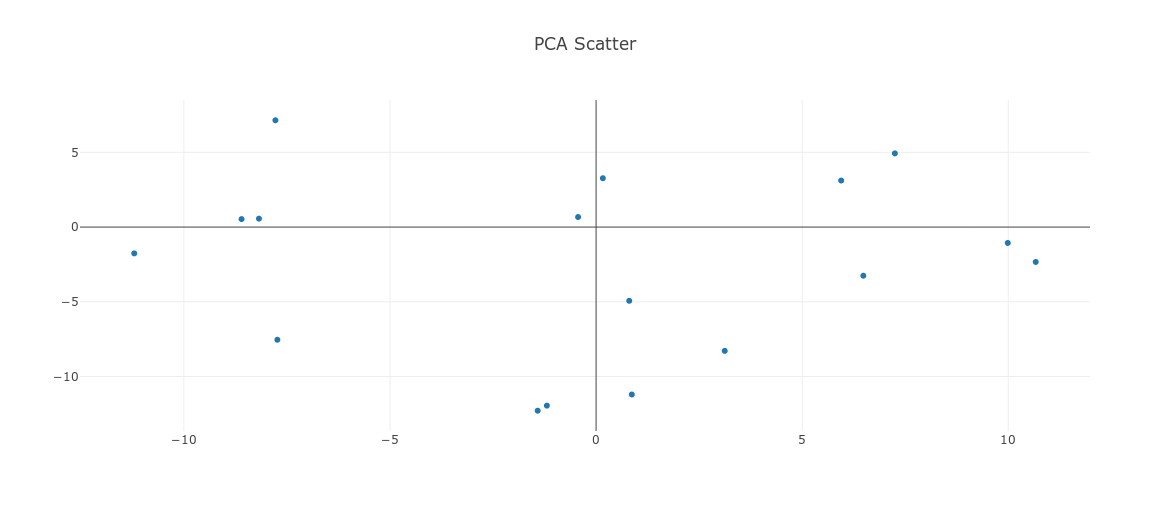

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

PCA_df = oskar.PCA(df, "hgvauser@platinum:illumina_platinum", 2).toPandas()
samples = oskar.metadata.samples(df, "hgvauser@platinum:illumina_platinum")

X = []
for i in PCA_df["PCA"]:
    X.append(i[0])
Y = []
for i in PCA_df["PCA"]:
    Y.append(i[1])

trace = go.Scatter(x = X, y = Y, text = samples, mode = 'markers')
fig = go.Figure(data = [trace])
fig['layout'].update({"title":"PCA Scatter", 'width':1440, 'height':500})

py.iplot(fig)

** If you are using jupyter lab you will need to download this extension https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension to visualize the plot*

<br>

# Analysis by pairs

## Identity by state
An interesting test we may want to execute is IBS, wich could give us important information about genotype similarity.
<br>
<br>
Usage:
```python
ibd(df[DataFrame], samples[list<str>]=None, skipMultiAllelic[bool]=None, skipReference[bool]=None, numPairs[int]=None)
```

In [26]:
oskar.ibs(df).show(10)

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|
|[NA12877, NA12883]| 0.891156462585034|[0, 64, 230]|     294| 706|
|[NA12877, NA12884]|0.8904109589041096|[0, 64, 228]|     292| 708|
|[NA12877, NA12885]|0.9115755627009646|[0, 55, 256]|     311| 689|
|[NA12877, NA12886]| 0.909967845659164|[0, 56, 255]|     311| 689|
|[NA12877, NA12887]|0.9096989966555183|[0, 54, 245]|     299| 701|
+------------------+------------------+------------+--------+----+
only showing top 10 rows



In case we don't specify any samples it will run the whole dataframe samples, but we may want to check similarity between particular individuals:

In [3]:
oskar.ibs(df, samples = ["NA12877", "NA12878", "NA12879", "NA12880", "NA12881", "NA12882"]).show()

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|
|[NA12878, NA12879]|0.8857615894039735|[0, 69, 233]|     302| 698|
|[NA12878, NA12880]|0.8888888888888888|[0, 72, 252]|     324| 676|
|[NA12878, NA12881]|0.8931888544891641|[0, 69, 254]|     323| 677|
|[NA12878, NA12882]|0.9064516129032258|[0, 58, 252]|     310| 690|
|[NA12879, NA12880]|0.9016666666666666|[0, 59, 241]|     300| 700|
|[NA12879, NA12881]|0.9033333333333333|[0, 58, 242]|     300| 700|
|[NA12879, NA12882]|0.9325259515570934|[0, 39, 250]|     289| 

## Identity by descent
Some other interesting test we may want to execute is IBD, wich could give us important information about common ancestors.
<br>
<br>
Usage:
```python
ibd(df[DataFrame], samples[list<str>]=None, skipMultiAllelic[bool]=None, skipReference[bool]=None, numPairs[int]=None)
```

In [27]:
oskar.ibd(df).show(10)

+------------------+------------------+------------+--------+----+---------------+------+
|        samplePair|          distance|      counts|variants|skip|            IBD|PI_HAT|
+------------------+------------------+------------+--------+----+---------------+------+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12883]| 0.891156462585034|[0, 64, 230]|     294| 706|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12884]|0.8904109589041096|[0, 64, 228]|     292| 708|[NaN, NaN, NaN]|   NaN|
|[NA12877, NA12885]|0.9115755627009646|[0, 55, 256]|     311| 689|[NaN, NaN, NaN]|   NaN|
|[NA12877,

In [33]:
# oskar.ibd(df, samples = ["NA12880", "NA12881", "NA12882", "NA12883", "NA12884"]).show(10)

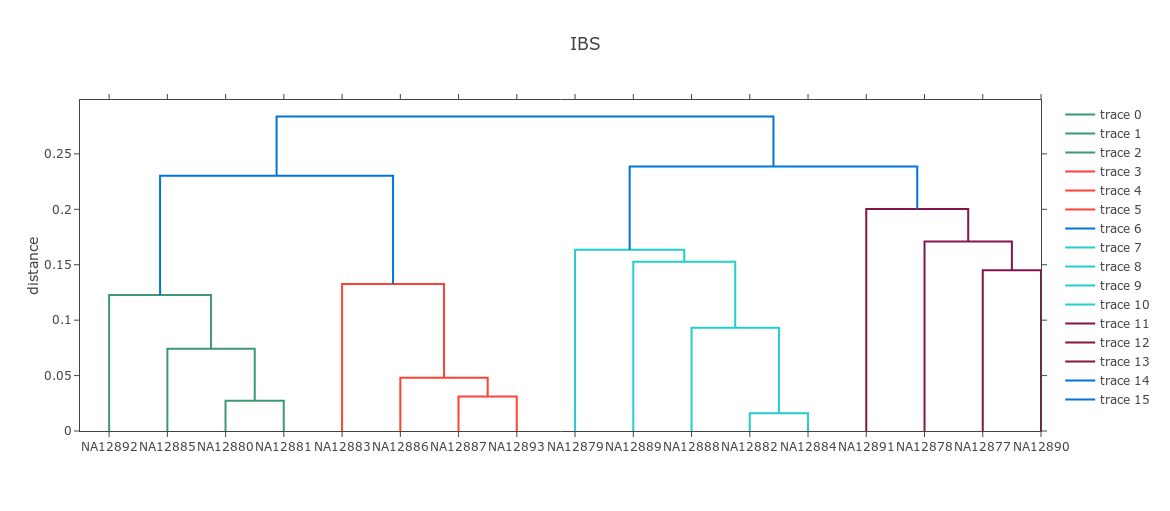

In [3]:
import numpy as np
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)

OskarIBS = oskar.ibs(df).toPandas()
samples_list = []
samples_dict = {}
num_of_values = len(OskarIBS)
for i in range(len(OskarIBS)):
    sample = OskarIBS["samplePair"][i][0]
    if not sample in samples_dict:
        samples_list.append(sample)
        samples_dict[sample] = []
    samples_dict[sample].append(1 - OskarIBS["distance"][i])
samples_dict[OskarIBS["samplePair"][num_of_values - 1][1]] = []
samples_list.append(OskarIBS["samplePair"][num_of_values - 1][1])

num_of_samples = len(samples_dict)
X = np.zeros((num_of_samples,num_of_samples))

for j in range(0, num_of_samples - 1):    
    for i in range(j + 1, num_of_samples):
        X[i,j] = samples_dict[samples_list[j]][i - 1 - j]
        X[j,i] = samples_dict[samples_list[j]][i - 1 - j]

fig = ff.create_dendrogram(X, labels = samples_list, color_threshold = 0.21)
yaxis = {'title': 'distance'}
fig['layout'].update({'title':'IBS', 'width':1440, 'height':500, 'showlegend':True, 'yaxis':yaxis})

py.iplot(fig)

** If you are using jupyter lab you will need to download this extension https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension to visualize the plot*

<br>

# GWAS

These GWAS transformers take the poblational information stored in the DataFrame metadata to calculate the corresponding significance values. The user will need to specify a particular study and the phenotype he aims to analyze. 
<br>
<br>
NOTE: Knowing the DataFrame structure and how to access it with Python default syntax is highly recommended to make the most of PyOskar API. For better understanding of the DataFrame metadata go to _metadata_ tutorial
<br>
<br>
This is how the metadata pertaining to the samples looks like:

In [4]:
variant_metadata = oskar.metadata.variantMetadata(df)
print(variant_metadata["studies"][0]["individuals"])

[{'id': 'NA12877', 'family': 'FF', 'father': 'NA12889', 'mother': 'NA12890', 'sex': 'MALE', 'phenotype': 'JJ', 'samples': [{'id': 'NA12877', 'annotations': {}}]}, {'id': 'NA12878', 'family': 'FF', 'father': 'NA12891', 'mother': 'NA12892', 'sex': 'FEMALE', 'phenotype': 'LL', 'samples': [{'id': 'NA12878', 'annotations': {}}]}, {'id': 'NA12879', 'family': 'FF', 'father': 'NA12877', 'mother': 'NA12878', 'sex': 'FEMALE', 'phenotype': 'JJ', 'samples': [{'id': 'NA12879', 'annotations': {}}]}, {'id': 'NA12880', 'family': 'FF', 'father': 'NA12877', 'mother': 'NA12878', 'sex': 'FEMALE', 'phenotype': 'KK', 'samples': [{'id': 'NA12880', 'annotations': {}}]}, {'id': 'NA12881', 'family': 'FF', 'father': 'NA12877', 'mother': 'NA12878', 'sex': 'FEMALE', 'phenotype': 'JJ', 'samples': [{'id': 'NA12881', 'annotations': {}}]}, {'id': 'NA12882', 'family': 'FF', 'father': 'NA12877', 'mother': 'NA12878', 'sex': 'MALE', 'phenotype': 'JJ', 'samples': [{'id': 'NA12882', 'annotations': {}}]}, {'id': 'NA12883', '

## Chi-squared
Usage:
```python
chiSquare(df[DataFrame], studyId[str], phenotype[str])
```

In [28]:
oskar.chiSquare(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value")).show(10)

+---------------+-------------------+
|             id|  ChiSquare p-value|
+---------------+-------------------+
|22:16054454:C:T|0.11583677431831574|
|22:16065809:T:C| 0.8162967146689325|
|22:16077310:T:A| 0.3243241555798487|
|22:16080499:A:G|0.16932729721206297|
|22:16084621:T:C|0.11808572685033702|
|22:16091610:G:T|0.24164568184122925|
|22:16096040:G:A|0.24839711482150617|
|22:16099957:C:T| 0.9283082406877704|
|22:16100462:A:G| 0.8244791006886252|
|22:16105660:G:A| 0.9612450306338958|
+---------------+-------------------+
only showing top 10 rows



## Fisher
Usage:
```python
fisher(df[DataFrame], studyId[str], phenotype[str])
```

In [30]:
oskar.fisher(df, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value")).show(10)

+---------------+-------------------+
|             id|     Fisher p-value|
+---------------+-------------------+
|22:16054454:C:T| 0.2941176470588194|
|22:16065809:T:C| 0.9999999999999629|
|22:16077310:T:A| 0.6444578943924588|
|22:16080499:A:G|0.29575642573744654|
|22:16084621:T:C| 0.2907969639468656|
|22:16091610:G:T| 0.5387700534759321|
|22:16096040:G:A|0.39512983254395534|
|22:16099957:C:T| 0.9999999999999654|
|22:16100462:A:G| 0.9999999999999866|
|22:16105660:G:A| 0.9999999999999954|
+---------------+-------------------+
only showing top 10 rows



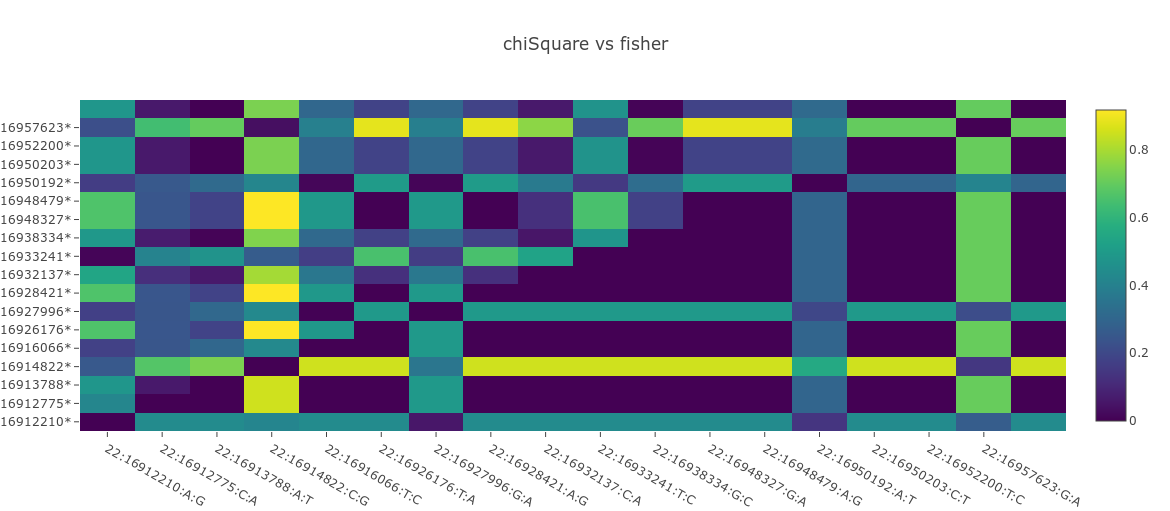

In [4]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode

init_notebook_mode(connected = True)

SLCdf = df.filter(array_contains(genes("annotation"), "SLC9B1P4"))

pandasFisher = oskar.fisher(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("Fisher p-value").alias("fisher")).toPandas()
pandasChiSquare = oskar.chiSquare(SLCdf, "hgvauser@platinum:illumina_platinum", "KK").select("id", col("ChiSquare p-value").alias("chiSquare")).toPandas()

labels = pandasFisher["id"].tolist()
labelsPosition = [i.split(":", 3)[1] + "*" for i in labels]

# dim = len(labels)
# X = np.zeros((dim, dim))
# for i in range(dim):
#     for j in range(dim):
#         X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

dim = len(labels)
X = np.zeros((dim, dim))
for i in range(dim):
    for j in range(i, dim):
        X[i, j] = np.absolute(pandasFisher["fisher"][i] - pandasFisher["fisher"][j])
for i in range(dim):
    for j in range(i, dim):
        X[j, i] = np.absolute(pandasChiSquare["chiSquare"][i] - pandasChiSquare["chiSquare"][j])

trace = go.Heatmap(x = labels, y = labelsPosition, z = X, colorscale = 'Viridis')
fig = go.Figure(data = [trace])
fig['layout'].update({ 'title':'chiSquare vs fisher', 'width':1440, 'height':500})

py.iplot(fig)